In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files

In [2]:
!pip install keras_tuner
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2011completefinaldatasets.csv')

data.shape

(720, 8)

# Exploratory Data Analysis

In [5]:
# Convert "Time" to datetime and set as index
data['Time'] = pd.to_datetime(data['Time'] + '-1', format='%Y-w%W-%w')

data.head(), data.tail()

(        Time  Rainfall  MaxTemperature  AverageTemperature  MinTemperature  \
 0 2011-01-03  9.938571       29.444400           25.888890       23.888900   
 1 2011-01-10  8.587143       30.000000           26.705556       24.444444   
 2 2011-01-17  5.338571       30.000000           26.616667       25.000000   
 3 2011-01-24  5.410000       30.555556           26.483333       20.555556   
 4 2011-01-31  2.914286       28.333333           25.283333       18.650000   
 
     Wind   Humidity  Cases  
 0  11.39  86.242857      5  
 1   7.32  88.028571      4  
 2   7.55  84.028571      2  
 3  10.67  80.971429      7  
 4  11.01  74.885714      2  ,
           Time  Rainfall  MaxTemperature  AverageTemperature  MinTemperature  \
 715 2024-09-30     1.016       33.333333           28.866667       25.555556   
 716 2024-10-07     9.652       32.777778           28.561111       25.000000   
 717 2024-10-14    25.400       33.333333           29.083333       25.000000   
 718 2024-10-21    

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Time                720 non-null    datetime64[ns]
 1   Rainfall            720 non-null    float64       
 2   MaxTemperature      720 non-null    float64       
 3   AverageTemperature  720 non-null    float64       
 4   MinTemperature      720 non-null    float64       
 5   Wind                720 non-null    float64       
 6   Humidity            720 non-null    float64       
 7   Cases               720 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 45.1 KB


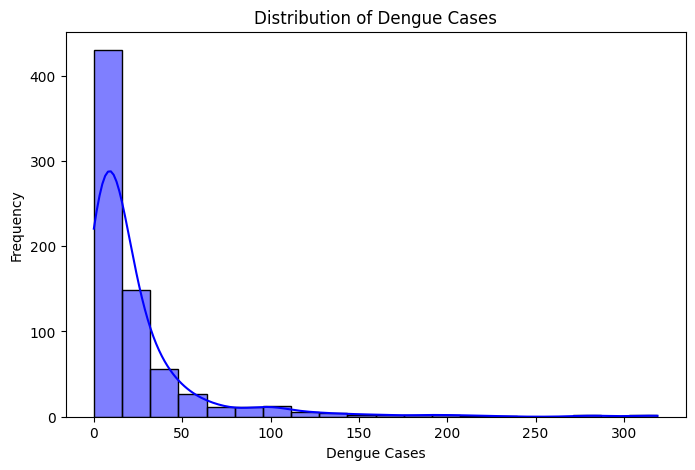

,Time,Rainfall,MaxTemperature,AverageTemperature,MinTemperature,Wind,Humidity,Cases
count,720,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,2017-12-02 11:22:00,13.957499,32.191142,28.110319,25.038472,6.172417,81.609442,23.744444
min,2011-01-03 00:00:00,0.000000,-14.600000,24.494444,12.222222,1.910000,73.185714,0.000000
25%,2014-06-21 06:00:00,1.270000,31.666667,27.504167,25.000000,4.117500,79.885713,5.000000
50%,2017-12-07 12:00:00,4.318000,32.222222,28.161111,25.000000,5.725000,81.771429,12.000000
75%,2021-05-11 18:00:00,10.414000,32.777778,28.751389,25.555556,7.860000,83.503571,26.000000
max,2024-10-28 00:00:00,445.008000,58.333333,30.916667,32.222222,19.200000,89.571429,319.000000
std,NaN,35.448846,2.616379,0.999800,1.291659,2.446703,2.831674,37.144813


In [7]:
# Summary statistics
summary_stats = data.describe()

# Distribution of dengue cases
plt.figure(figsize=(8, 5))
sns.histplot(data["Cases"], bins=20, kde=True, color="blue")
plt.xlabel("Dengue Cases")
plt.ylabel("Frequency")
plt.title("Distribution of Dengue Cases")
plt.show()

# Display summary statistics
summary_stats

In [8]:
# # Categorizing dengue cases into intervals
# bins = [0, 5, 15, 30, 100, 320]  # Case intervals
# labels = ["0-5", "6-15", "16-30", "31-100", "101+"]  # Interval labels
# data["Cases_Interval"] = pd.cut(data["Cases"], bins=bins, labels=labels, right=False)

# # Count plot for different case intervals
# plt.figure(figsize=(8, 5))
# sns.countplot(x="Cases_Interval", data=data, palette="coolwarm", order=labels)
# plt.xlabel("Dengue Case Intervals")
# plt.ylabel("Frequency")
# plt.title("Frequency of Dengue Cases in Different Intervals")
# plt.show()

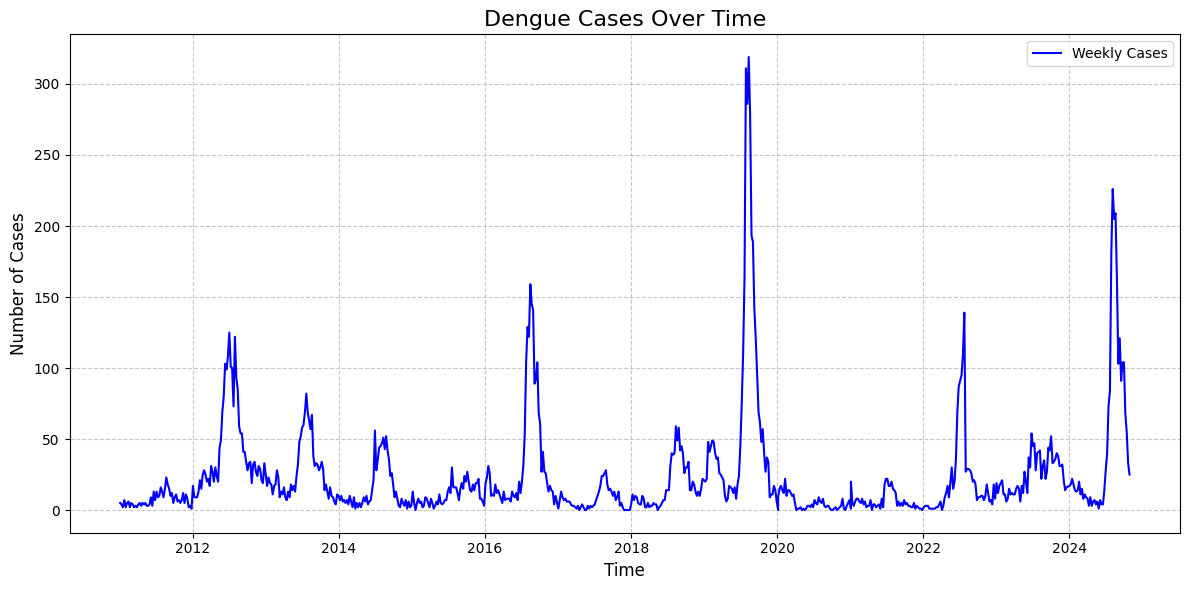

In [9]:
# Analyze the cases over time to observe seasonality
plt.figure(figsize=(12, 6))
plt.plot(data['Time'][:len(data)], data['Cases'], color='blue', label='Weekly Cases')
plt.title('Dengue Cases Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Compute correlation between weather factors and cases
correlation_matrix = data.corr()
case_correlation = correlation_matrix['Cases'].sort_values(ascending=False)

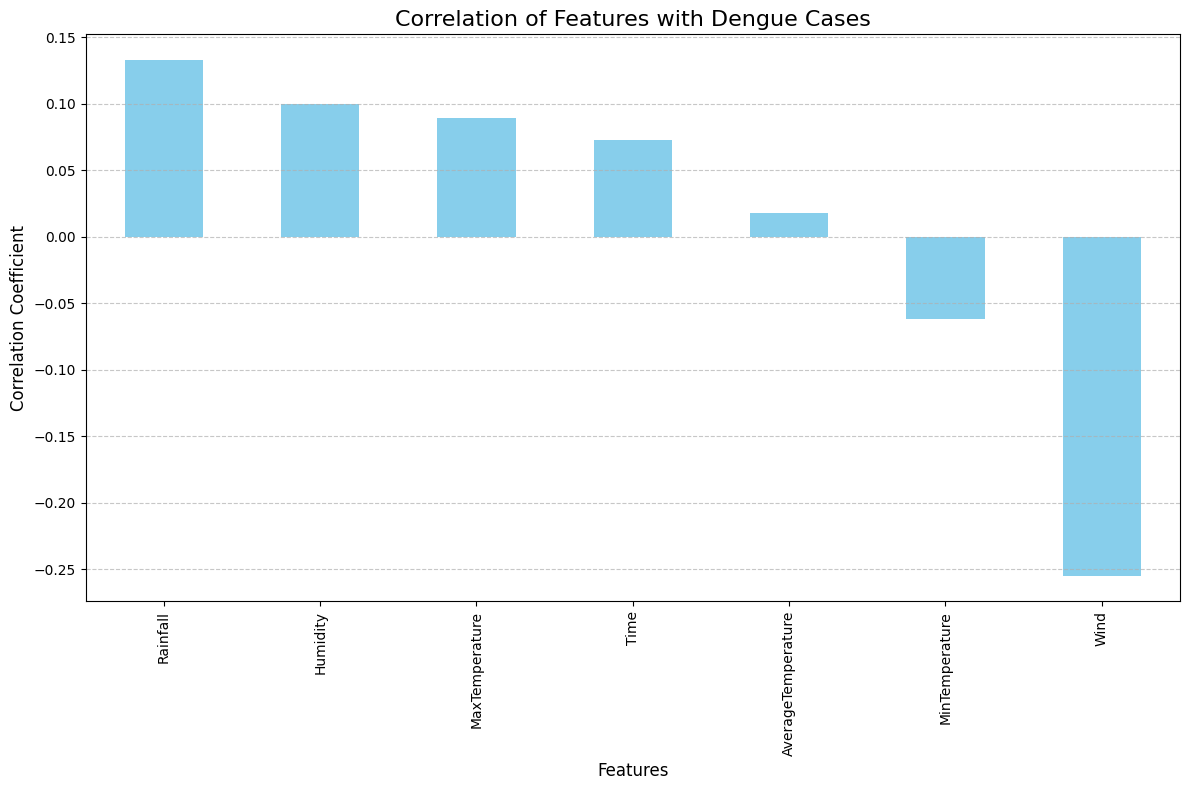

In [11]:
# Plot correlation of all features with Cases
plt.figure(figsize=(12, 8))
case_correlation.drop('Cases').plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Dengue Cases', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Identify top 3 correlated weather factors with cases
top_3_factors = case_correlation.index[1:4]

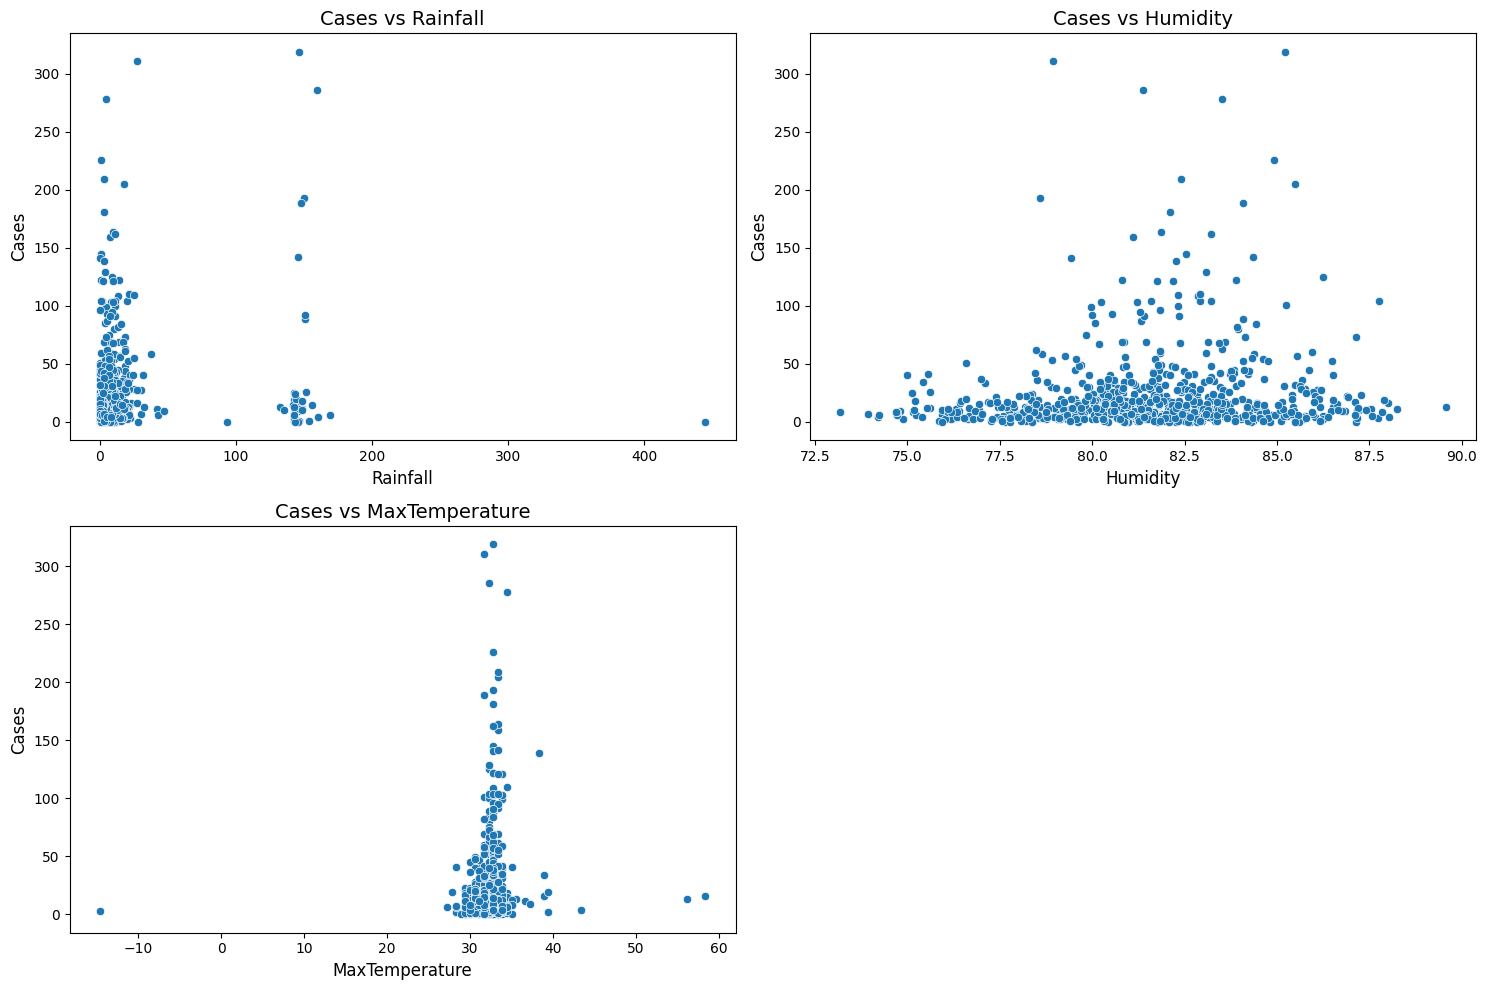

In [13]:
# Plot relationships between top factors and cases
plt.figure(figsize=(15, 10))
for i, factor in enumerate(top_3_factors, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=data[factor], y=data['Cases'], edgecolor='w')
    plt.title(f'Cases vs {factor}', fontsize=14)
    plt.xlabel(factor, fontsize=12)
    plt.ylabel('Cases', fontsize=12)
plt.tight_layout()
plt.show()

#Outbreak Computation

In [14]:
# Get the last four datapoints (1 month)
last_four_rows = data.tail(4)

# Create a new DataFrame containing the last four rows
last_four_df = data.tail(4)

# Summary statistics for the entire dataset
month_summary_stats = last_four_df.describe()

# Display the summary statistics
print(month_summary_stats)

                      Time   Rainfall  MaxTemperature  AverageTemperature  \
count                    4   4.000000        4.000000            4.000000   
mean   2024-10-17 12:00:00  14.541500       32.500000           28.348611   
min    2024-10-07 00:00:00   2.540000       31.666667           27.455556   
25%    2024-10-12 06:00:00   7.874000       32.083333           28.084722   
50%    2024-10-17 12:00:00  15.113000       32.500000           28.427778   
75%    2024-10-22 18:00:00  21.780500       32.916667           28.691667   
max    2024-10-28 00:00:00  25.400000       33.333333           29.083333   
std                    NaN  10.364061        0.717219            0.679572   

       MinTemperature      Wind   Humidity      Cases  
count        4.000000  4.000000   4.000000   4.000000  
mean        24.861111  5.265000  84.128571  45.250000  
min         23.888889  4.260000  82.385714  25.000000  
25%         24.722222  4.597500  83.607143  31.000000  
50%         25.000000  4.8

#Training

In [15]:
# Select features for normalization (excluding the target column)
features = data[['Rainfall', 'MaxTemperature','Humidity']]
target = data['Cases']

features.shape, target.shape

((720, 3), (720,))

In [16]:
# Normalize the features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

normalized_features = scaler_features.fit_transform(features)
normalized_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# Convert back to DataFrame for better manipulation
normalized_data = pd.DataFrame(normalized_features, columns=features.columns, index=data.index)
normalized_data['Cases'] = normalized_target

In [17]:
normalized_data.head()

,Rainfall,MaxTemperature,Humidity,Cases
0,0.022333,0.603899,0.796861,0.015674
1,0.019297,0.611517,0.905841,0.012539
2,0.011997,0.611517,0.661726,0.006270
3,0.012157,0.619135,0.475153,0.021944
4,0.006549,0.588665,0.103749,0.006270


In [18]:
# Function to create sequences for LSTM
def create_sequences(data, target, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [19]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    # Tune the number of LSTM units
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), activation='relu'))

    # Output layer
    model.add(Dense(1))

    # Tune the learning rate
    lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    return model


In [20]:
# Initialize variables for results
window_sizes = [5, 10,20]
val_losses = []
histories = []
results = {}

In [21]:
n_splits = 3  # Number of time-based splits (adjustable)
tscv = TimeSeriesSplit(n_splits=n_splits)

results = {}  # Store results for different window sizes
val_losses = []  # Store validation losses for best window selection

for window_size in window_sizes:
    # Prepare sequences
    X, y = create_sequences(normalized_data.values, normalized_target, window_size)

    # Store metrics for each window size
    window_results = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X)):
        print(f"\nFold {fold+1} - Window Size {window_size}")

        # Train/test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Further split train into train & validation
        val_split_idx = int(len(X_train) * 0.8)
        X_train_final, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
        y_train_final, y_val = y_train[:val_split_idx], y_train[val_split_idx:]

        # Early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Hyperparameter tuning
        tuner = BayesianOptimization(
            hypermodel=build_model,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=2,
            overwrite=True,
            directory='kt_dir',
            project_name=f'dengue_lstm_tuning_ws{window_size}_fold{fold}',
            seed=42
        )

        tuner.search(X_train_final, y_train_final,
                     epochs=100,
                     validation_data=(X_val, y_val),
                     callbacks=[early_stop],
                     verbose=0)

        # Get best hyperparameters & build model
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)

        # Retrain model on full train (train + val) before testing
        history = model.fit(X_train, y_train,
                            epochs=100,
                            batch_size=1,
                            validation_split=0.1,  # Optional small val split
                            callbacks=[early_stop],
                            verbose=0)

        # Predict on test set
        y_pred = model.predict(X_test, verbose=0)

        # Inverse transform
        y_train_actual = scaler_target.inverse_transform(y_train.reshape(-1, 1))
        y_train_predicted = scaler_target.inverse_transform(model.predict(X_train).reshape(-1, 1))

        y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))
        y_test_predicted = scaler_target.inverse_transform(y_pred.reshape(-1, 1))

        # Compute metrics
        train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_predicted))
        test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_predicted))
        train_mae = mean_absolute_error(y_train_actual, y_train_predicted)
        test_mae = mean_absolute_error(y_test_actual, y_test_predicted)
        train_r2 = r2_score(y_train_actual, y_train_predicted)
        test_r2 = r2_score(y_test_actual, y_test_predicted)

        # Store fold results
        window_results.append({
            'fold': fold + 1,
            'train_rmse': train_rmse,
            'train_mae': train_mae,
            'train_r2': train_r2,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'best_units': best_hps.get('units'),
            'best_lr': best_hps.get('lr'),
            'train_actual': y_train_actual.flatten(),
            'train_predicted': y_train_predicted.flatten(),
            'test_actual': y_test_actual.flatten(),
            'test_predicted': y_test_predicted.flatten()
        })

    # Save results for this window size
    results[window_size] = window_results

    # Store validation loss to determine best window size
    val_losses.append(np.mean([fold['test_rmse'] for fold in window_results]))


Fold 1 - Window Size 5
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Fold 2 - Window Size 5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Fold 3 - Window Size 5
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Fold 1 - Window Size 10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Fold 2 - Window Size 10


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Fold 3 - Window Size 10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Fold 1 - Window Size 20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Fold 2 - Window Size 20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Fold 3 - Window Size 20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [22]:
# Print Training Metrics for Different Window Sizes
print("\n--- TRAINING METRICS ---")
for window_size, result in results.items():
    avg_train_rmse = np.mean([fold['train_rmse'] for fold in result])
    avg_train_mae = np.mean([fold['train_mae'] for fold in result])
    avg_train_r2 = np.mean([fold['train_r2'] for fold in result])
    print(f"Window {window_size} - RMSE: {avg_train_rmse:.2f}, MAE: {avg_train_mae:.2f}, R2: {avg_train_r2:.2f}")


--- TRAINING METRICS ---
Window 5 - RMSE: 11.26, MAE: 7.00, R2: 0.85
Window 10 - RMSE: 11.59, MAE: 8.04, R2: 0.83
Window 20 - RMSE: 11.84, MAE: 7.00, R2: 0.83


In [23]:
# Print Testing Metrics for Different Window Sizes
print("\n--- TESTING METRICS ---")
for window_size, result in results.items():
    avg_test_rmse = np.mean([fold['test_rmse'] for fold in result])
    avg_test_mae = np.mean([fold['test_mae'] for fold in result])
    avg_test_r2 = np.mean([fold['test_r2'] for fold in result])
    print(f"Window {window_size} - RMSE: {avg_test_rmse:.2f}, MAE: {avg_test_mae:.2f}, R2: {avg_test_r2:.2f}")


--- TESTING METRICS ---
Window 5 - RMSE: 16.69, MAE: 9.06, R2: 0.79
Window 10 - RMSE: 17.08, MAE: 10.40, R2: 0.75
Window 20 - RMSE: 16.93, MAE: 8.75, R2: 0.81


# Evaluation Metrics

In [34]:
# Store time indices for each fold (train and test)
for window_size, folds in results.items():
    X, y = create_sequences(normalized_data.values, normalized_target, window_size)
    time_index = data['Time'][window_size:]  # Adjust for sequence length
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        train_time = time_index.to_numpy()[train_idx]
        test_time = time_index.to_numpy()[test_idx]
        results[window_size][fold]['train_time'] = train_time
        results[window_size][fold]['test_time'] = test_time


#Training Set

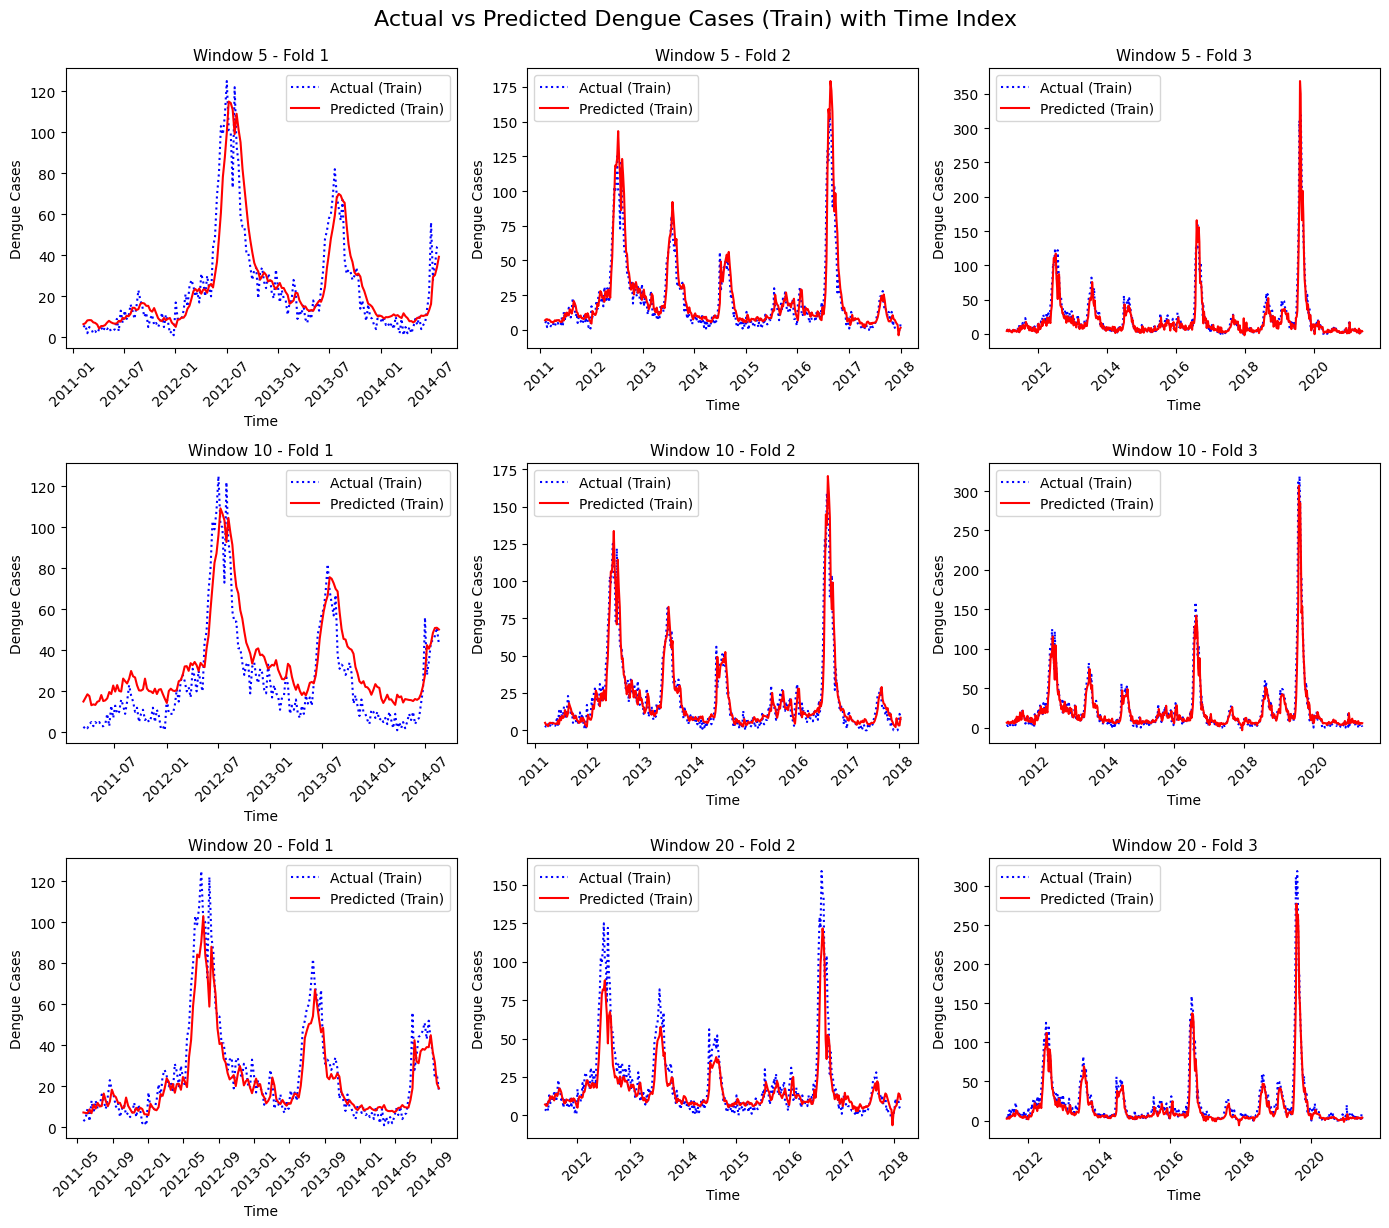

In [36]:
plt.figure(figsize=(14, 4 * len(results)))
for i, (window_size, folds) in enumerate(results.items(), 1):
    for j, fold_result in enumerate(folds):
        plt.subplot(len(results), len(folds), (i - 1) * len(folds) + j + 1)
        plt.plot(fold_result['train_time'], fold_result['train_actual'], label='Actual (Train)', linestyle='dotted', color='blue')
        plt.plot(fold_result['train_time'], fold_result['train_predicted'], label='Predicted (Train)', color='red')
        plt.title(f'Window {window_size} - Fold {fold_result["fold"]}', fontsize=11)
        plt.xlabel('Time')
        plt.ylabel('Dengue Cases')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
plt.suptitle("Actual vs Predicted Dengue Cases (Train) with Time Index", fontsize=16, y=1.02)
plt.show()


#Test Set

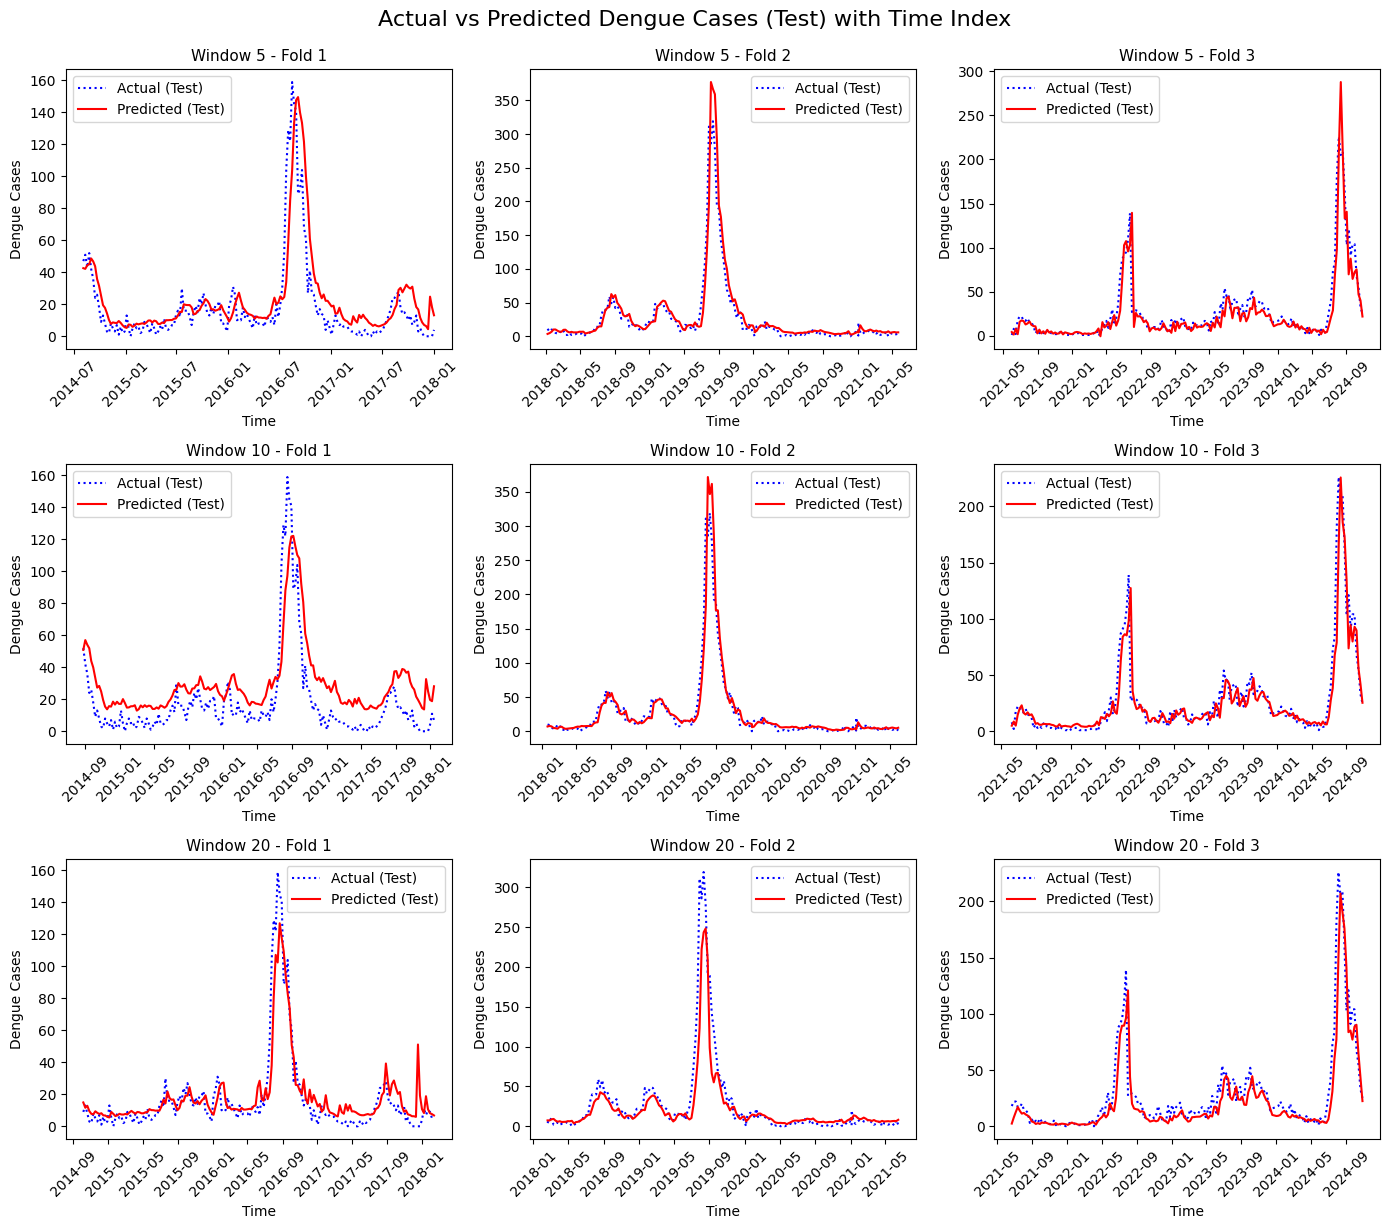

In [37]:
plt.figure(figsize=(14, 4 * len(results)))
for i, (window_size, folds) in enumerate(results.items(), 1):
    for j, fold_result in enumerate(folds):
        plt.subplot(len(results), len(folds), (i - 1) * len(folds) + j + 1)
        plt.plot(fold_result['test_time'], fold_result['test_actual'], label='Actual (Test)', linestyle='dotted', color='blue')
        plt.plot(fold_result['test_time'], fold_result['test_predicted'], label='Predicted (Test)', color='red')
        plt.title(f'Window {window_size} - Fold {fold_result["fold"]}', fontsize=11)
        plt.xlabel('Time')
        plt.ylabel('Dengue Cases')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
plt.suptitle("Actual vs Predicted Dengue Cases (Test) with Time Index", fontsize=16, y=1.02)
plt.show()


In [26]:
# 🎯 Display best hyperparameters for different window sizes
print("\n--- Best Hyperparameters for Each Window Size ---")
for window_size, result in results.items():
    best_units = result[0]['best_units']
    best_lr = result[0]['best_lr']
    print(f"Window Size {window_size}: Units = {best_units}, Learning Rate = {best_lr}")



--- Best Hyperparameters for Each Window Size ---
Window Size 5: Units = 64, Learning Rate = 0.01
Window Size 10: Units = 48, Learning Rate = 0.01
Window Size 20: Units = 112, Learning Rate = 0.01


### Choose the best window size

In [27]:
# Find Best Window Size Based on Validation Loss
best_index = np.argmin(val_losses)
best_window_size = window_sizes[best_index]
print(f"\n Best Window Size: {best_window_size}")


 Best Window Size: 5
